In [66]:
import sys
sys.path.append('../../')
import helper

import numpy as np
from pandas import read_excel, DataFrame, get_dummies
from matplotlib import pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau


## 문제2

아래의 데이터셋은 미국 국립 당뇨병, 소화기 및 신장 질환 연구소에서 가져온 것으로 데이터세트의 목적은 데이터세트에 포함된 특정 진단 측정값을 기반으로 환자에게 당뇨병이 있는지 여부를 진단적으로 예측하는 것입니다.

> https://data.hossam.kr/F03/pima-indians.xlsx

전체 모집단으로부터 몇 가지 제약이 적용되어 표본이 추출되었습니다.

> 피마 인디언 혈통의 21세 이상의 여성

데이터 세트는 여러 개의 의료 독립 변수와 하나의 종속 변수로 구성됩니다

종속 변수는 Outcome이며 독립 변수에는 환자의 임신 횟수, BMI, 인슐린 수준, 연령 등이 포함됩니다.

이 데이터셋을 활용하여 당뇨병 발병 여부를 판단할 수 있는 분류 모델을 구현하시오.

적용해야 하는 분석모델의 종류는 데이터의 형태에 따라 스스로 결정해야 합니다.

In [67]:
origin = read_excel('https://data.hossam.kr/F03/pima-indians.xlsx')
origin.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [68]:
origin.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

데이터를 보고, Outcome이 이항분류로 나눌 수 있음을 확인. 로지스틱으로 풀이 

In [69]:
# 명목형 변수 형변환 -> 미리 카테고리 타입으로 바꿔야, 매번 필터를 걸지 않는다.
origin['Outcome'] = origin['Outcome'].astype('category')
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Pregnancies               768 non-null    int64   
 1   Glucose                   768 non-null    int64   
 2   BloodPressure             768 non-null    int64   
 3   SkinThickness             768 non-null    int64   
 4   Insulin                   768 non-null    int64   
 5   BMI                       768 non-null    float64 
 6   DiabetesPedigreeFunction  768 non-null    float64 
 7   Age                       768 non-null    int64   
 8   Outcome                   768 non-null    category
dtypes: category(1), float64(2), int64(6)
memory usage: 49.0 KB


In [70]:
origin.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


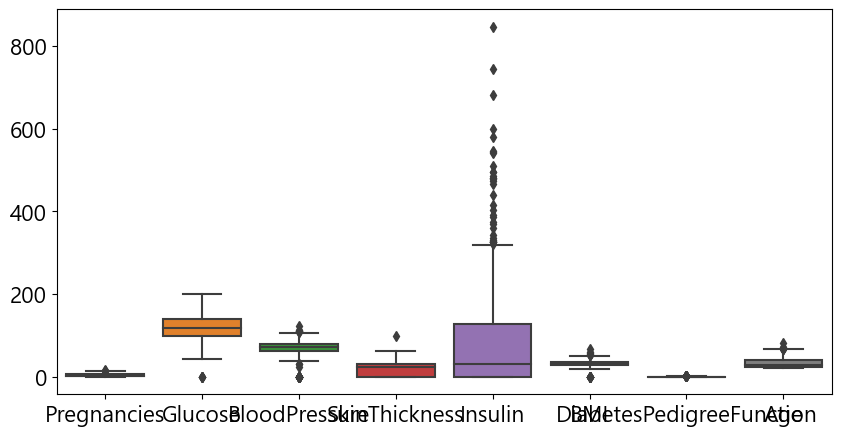

In [71]:
# 회귀가 아니라서 산점도는 필요없고, 상자그림만 확인 
plt.figure(figsize=(10,5))
sb.boxplot(data=origin)
plt.show()
plt.close()

데이터분포가 상이하므로 표준화가 필요하다고 판단

In [72]:
np.random.seed(777)

In [73]:
# 훈련데이터와 레이블 구분

x = origin.drop('Outcome',axis=1)
y = origin[['Outcome']]
x.shape, y.shape

((768, 8), (768, 1))

In [74]:
from sklearn.preprocessing import StandardScaler

In [75]:
# 데이터 표준화
x_scaller = StandardScaler()
x_scale = x_scaller.fit_transform(x)
x_scale_df = DataFrame(x_scale,columns=x.columns, index=x.index)

x_scale_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.848324,0.149641,0.907270,-0.692891,0.204013,0.468492,1.425995
1,-0.844885,-1.123396,-0.160546,0.530902,-0.692891,-0.684422,-0.365061,-0.190672
2,1.233880,1.943724,-0.263941,-1.288212,-0.692891,-1.103255,0.604397,-0.105584
3,-0.844885,-0.998208,-0.160546,0.154533,0.123302,-0.494043,-0.920763,-1.041549
4,-1.141852,0.504055,-1.504687,0.907270,0.765836,1.409746,5.484909,-0.020496


In [76]:
# 훈련데이터와 검증 데이터로 분할
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((537, 8), (231, 8), (537, 1), (231, 1))

In [77]:
# 모델 정의
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(len(x_train.columns), )))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                288       
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 321 (1.25 KB)
Trainable params: 321 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [78]:
# 학습하기

result = model.fit(x_train, y_train, epochs = 500, validation_data = (x_test, y_test), callbacks = [
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
])

Epoch 1/500


17/17 [==============================] - 1s 10ms/step - loss: 7.1150 - acc: 0.3743 - val_loss: 3.9676 - val_acc: 0.4069 - lr: 0.0010
Epoch 2/500
17/17 [==============================] - 0s 3ms/step - loss: 3.1056 - acc: 0.4898 - val_loss: 2.4448 - val_acc: 0.4589 - lr: 0.0010
Epoch 3/500
17/17 [==============================] - 0s 3ms/step - loss: 2.1562 - acc: 0.5158 - val_loss: 1.7347 - val_acc: 0.5887 - lr: 0.0010
Epoch 4/500
17/17 [==============================] - 0s 3ms/step - loss: 1.6089 - acc: 0.5363 - val_loss: 1.3855 - val_acc: 0.5325 - lr: 0.0010
Epoch 5/500
17/17 [==============================] - 0s 3ms/step - loss: 1.3494 - acc: 0.5680 - val_loss: 1.1840 - val_acc: 0.6710 - lr: 0.0010
Epoch 6/500
17/17 [==============================] - 0s 3ms/step - loss: 1.1182 - acc: 0.5810 - val_loss: 1.0298 - val_acc: 0.6537 - lr: 0.0010
Epoch 7/500
17/17 [==============================] - 0s 3ms/step - loss: 1.0730 - acc: 0.5959 - val_loss: 0.9390 - val_acc: 0.6277 - lr: 0.0010
Epo

정확도가 높으면 손실률은 안봐도 된다.

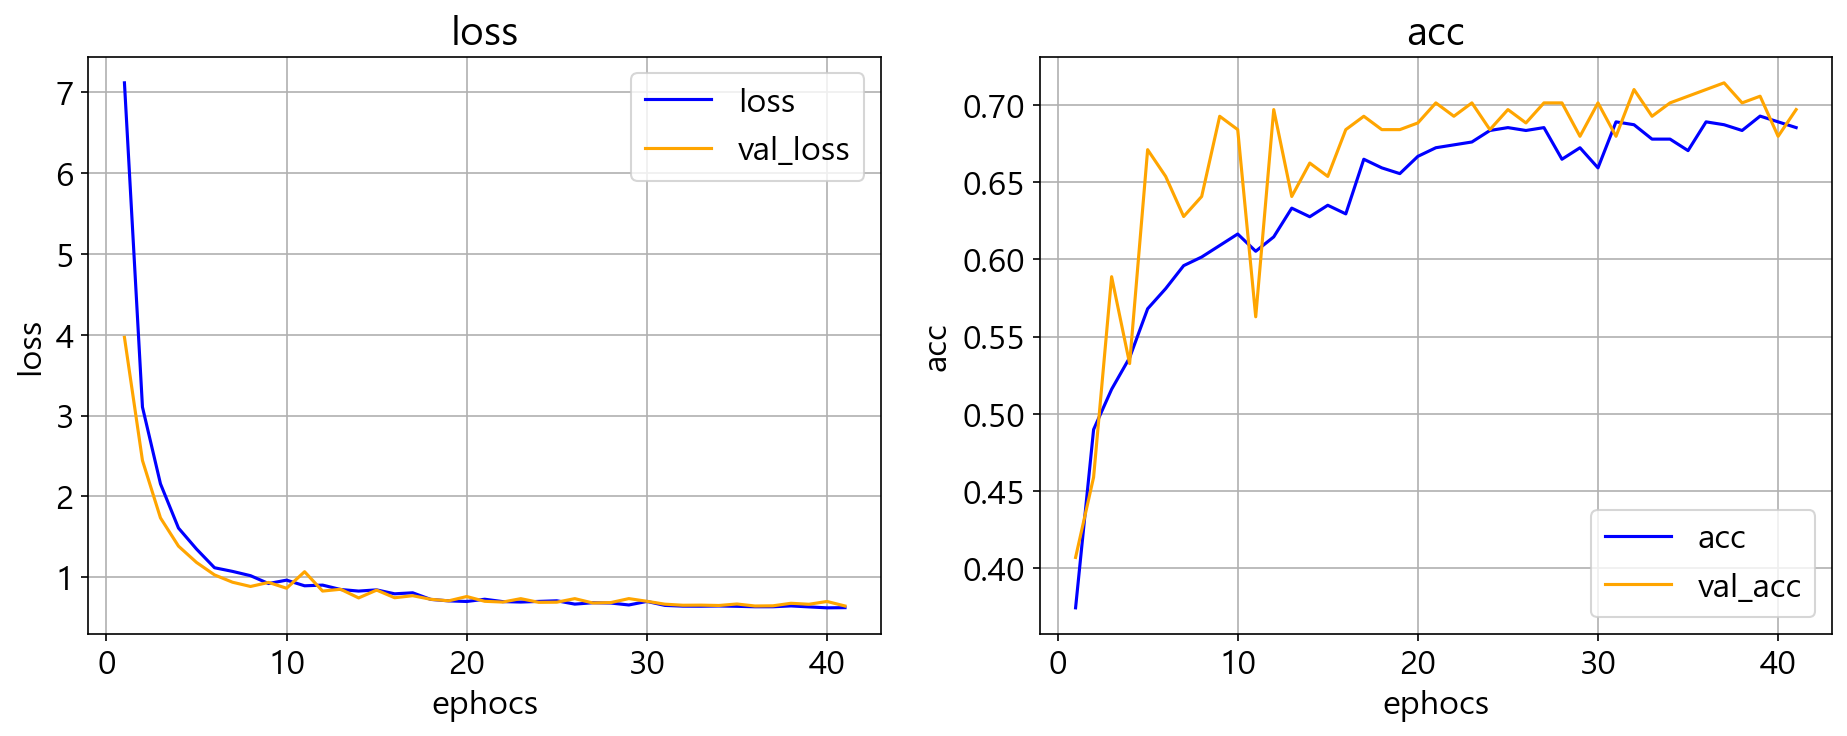

17/17 [==============================] - 0s 871us/step - loss: 0.6155 - acc: 0.6983
최종 훈련 손실률: 0.615539, 최종 훈련 정확도: 0.698324
8/8 [==============================] - 0s 0s/step - loss: 0.6454 - acc: 0.6970
최종 검증 손실률: 0.645415, 최종 검증 정확도: 0.696970


In [79]:
# 학습결과 평가

helper.tf_result_plot(result)

evaluate1 = model.evaluate(x_train, y_train)
print("최종 훈련 손실률: %f, 최종 훈련 정확도: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test)
print("최종 검증 손실률: %f, 최종 검증 정확도: %f" % (evaluate2[0], evaluate2[1]))

In [80]:
# 테스트 데이터에 대한 예측 결과 산정
train_pred = model.predict(x_train)
data_count, case_count = train_pred.shape
print(data_count,'개의 훈련 데이터가 ',case_count,'개의 경우의 수를 갖는다.')
train_pred

# 50%보다 작으면 0, 크면 1로 



17/17 [==============================] - 0s 1ms/step
537 개의 훈련 데이터가  1 개의 경우의 수를 갖는다.


array([[0.5543222 ],
       [0.70483077],
       [0.39278543],
       [0.31143498],
       [0.36330613],
       [0.14019144],
       [0.2210298 ],
       [0.6675363 ],
       [0.47018415],
       [0.53356093],
       [0.7716361 ],
       [0.21263118],
       [0.5503305 ],
       [0.21379697],
       [0.34792987],
       [0.2840328 ],
       [0.09125381],
       [0.34765276],
       [0.16624533],
       [0.36283576],
       [0.15249741],
       [0.27809703],
       [0.2851069 ],
       [0.5196048 ],
       [0.43629876],
       [0.3087309 ],
       [0.611801  ],
       [0.0423286 ],
       [0.28956133],
       [0.23733033],
       [0.07746331],
       [0.3503221 ],
       [0.18619905],
       [0.22392346],
       [0.7125854 ],
       [0.73768806],
       [0.21934104],
       [0.22196634],
       [0.7671276 ],
       [0.33736032],
       [0.23420419],
       [0.1320012 ],
       [0.16115847],
       [0.12680215],
       [0.35703006],
       [0.32997292],
       [0.20507437],
       [0.254

In [81]:
train_df = DataFrame({
    '관측치': y_train['Outcome'],
    '예측치': np.round(train_pred.flatten())
})

train_df

,관측치,예측치
335,0,1.0
130,1,1.0
255,1,0.0
573,0,0.0
764,0,0.0
...,...,...
669,0,0.0
71,0,1.0
599,0,0.0
571,0,0.0


In [82]:
# 검증 데이터에 대한 예측 결과 산정
test_pred = model.predict(x_test)
data_count, case_count = test_pred.shape
print("%d개의 검증 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
print(test_pred)

8/8 [==============================] - 0s 855us/step
231개의 검증 데이터가 1개의 경우의 수를 갖는다.
[[0.27040207]
 [0.6487447 ]
 [0.9671042 ]
 [0.35744348]
 [0.8580696 ]
 [0.34841082]
 [0.41116828]
 [0.37467778]
 [0.6077104 ]
 [0.48470348]
 [0.12010752]
 [0.12573025]
 [0.2938002 ]
 [0.4488513 ]
 [0.33349273]
 [0.14804608]
 [0.13151377]
 [0.20678857]
 [0.27625135]
 [0.13585402]
 [0.3505379 ]
 [0.33120713]
 [0.83073133]
 [0.53121525]
 [0.3461746 ]
 [0.37102327]
 [0.36318573]
 [0.5292652 ]
 [0.4185021 ]
 [0.29274687]
 [0.10801202]
 [0.33425313]
 [0.35638908]
 [0.1970743 ]
 [0.23781714]
 [0.07120378]
 [0.3253195 ]
 [0.650956  ]
 [0.14645424]
 [0.2745887 ]
 [0.6840323 ]
 [0.3883477 ]
 [0.3603208 ]
 [0.40521604]
 [0.4397137 ]
 [0.15208042]
 [0.2303479 ]
 [0.1972044 ]
 [0.08791235]
 [0.1836981 ]
 [0.8060303 ]
 [0.19066527]
 [0.11794047]
 [0.22395329]
 [0.78947765]
 [0.31531802]
 [0.23512207]
 [0.88988537]
 [0.53179204]
 [0.5442446 ]
 [0.21824582]
 [0.04350312]
 [0.65393037]
 [0.28741878]
 [0.5689449 ]
 [0.250

In [83]:
test_df = DataFrame({
    '관측치': y_train['Outcome'],
    '예측치': np.round(train_pred.flatten())
})

test_df

,관측치,예측치
335,0,1.0
130,1,1.0
255,1,0.0
573,0,0.0
764,0,0.0
...,...,...
669,0,0.0
71,0,1.0
599,0,0.0
571,0,0.0


In [84]:
# 결과 확인
logit = helper.tf_logit_result(model, result, x_train, y_train)
logit

17/17 [==============================] - 0s 1ms/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                288       
                                                                 
 dense_7 (Dense)             (None, 1)                 33        


                                                                 
Total params: 321 (1.25 KB)
Trainable params: 321 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [85]:
logit.cmdf

,Negative,Positive
True,284,105
False,57,91


In [86]:
logit.result_df.T

,0
정확도(Accuracy),0.698324
정밀도(Precision),0.614865
"재현율(Recall, TPR)",0.464286
"위양성율(Fallout, FPR)",0.167155
"특이성(Specificity, TNR)",0.832845
RAS,0.648565
f1_score,0.529070


In [87]:
logit.odds_rate_df

array([1.216391], dtype=float32)

In [88]:
# 결과 확인
# 왜 결과를 우리가 헬퍼로 학인해야 하나요... 


# 의학 모델은 정확도가 더 엄격하여 95% 이상을 목표로 한다.
